In [1]:

# coding: utf-8

# Autocorrelation to see if they are truly bimodal
# Use the MAP for the main graph. Highest probability chain.
# Try to run without MAP

# In[1]:
import numpy as np
import theano.tensor as tt
import pymc3 as pm
from scipy import stats
from pymc3 import Continuous
from theano import tensor 
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats
import threading
from multiprocessing.pool import ThreadPool
from astropy.table import Table
import pandas as pd
import os
import sys
#exp, log, sqrt

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
core_count = 20


# In[2]:


# In[3]:

def SuperNova_CurveRise_Scalar(t, A, B, t0, trise, scalar):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))+scalar
def SuperNova_CurveFall_Scalar(t, A, B, t0, gamma, trise, tfall, scalar):
    return (A + B*((gamma+t0)-t0))*np.exp(-(t-(gamma+t0))/tfall)/(1+np.exp(-(t-t0)/trise))+scalar


# In[4]:

def SuperNova_CurveRise(t, A, B, t0, trise):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))
def SuperNova_CurveFall(t, A, B, t0, gamma, trise, tfall):
    return (A + B*((gamma+t0)-t0))*np.exp(-(t-(gamma+t0))/tfall)/(1+np.exp(-(t-t0)/trise))


# In[5]:

def from_posteriors(param, samples):
    smins = []
    smaxs = []
    for i in samples:
        smins.append(np.min(i[param]))
        smaxs.append(np.max(i[param]))
    
    smin = np.min(smins)
    smax = np.max(smaxs)
    width = smax - smin

    x = np.linspace(smin, smax, 1000)
    ys = []
    for i in samples:
        ys.append(stats.gaussian_kde(i[param])(x))
    y = np.prod(ys, axis = 0)
    return Interpolated(param, x, y)


# In[6]:

def from_posterior(param, samples):
    smin, smax = np.min(samples[param]), np.max(samples[param])
    width = smax - smin
    x = np.linspace(smin, smax, 1000)
    y = stats.gaussian_kde(samples[param])(x)
    return Interpolated(param, x, y)


# In[7]:

def make_curve(param, samples):
    smins = []
    smaxs = []

    for i in samples:
        smins.append(np.min(i[param]))
        smaxs.append(np.max(i[param]))

    

    smin = np.min(smins)
    smax = np.max(smaxs)
    width = smax - smin

    x, step = np.linspace(smin, smax, 1000, retstep = True)
    ys = []
    for i in samples:
        ys.append(stats.gaussian_kde(i[param])(x))
    y = np.prod(ys, axis = 0)
    y = y + np.exp(-100)
    y_norm = y / (np.sum(y)*step)
    return param, x, y_norm
def make_prior(posterior_param):
    return Interpolated(posterior_param[0],posterior_param[1],posterior_param[2])


# In[8]:

def model_run(model,i,trace, iterations, core):
    with model:
        # 10000 posterior samples
        trace[i] = pm.sample(iterations, cores = core)


# In[9]:

path = "/home/xjh0560/Supernova_Lightcurves/LC_Data/"


# In[10]:

def SuperNova_Analysis(file):
# In[11]:
    ztf_data = pd.read_hdf(file)
    ztf_data = ztf_data.loc[ztf_data["programid"] == 1]

    filter_types = np.unique(ztf_data["filter"])
    filter_number = np.size(filter_types)


    # In[12]:

    #This is the test data we are going to use for a test
    time_axis_filters = []
    Y_observed_filter = []
    Y_unc = []
    scale = 10**(48.6/-2.5) * 1e23 * 1e6
    ztf_data['jdobs'] = ztf_data['jdobs']-np.min(ztf_data['jdobs'].values)
    end_A = np.max(ztf_data["jdobs"])
    filter_list = []
    for i in filter_types:
        filter_list.append(str(i).replace('\'',''))
        indicies = np.where(ztf_data["filter"] == i)
        time_axis_filters.append((ztf_data['jdobs'].values)[indicies])
        
        light_data = ((ztf_data['Fratio']).values)[indicies]
        Y_observed_filter.append(light_data*scale)
        
        light_data_unc = ((ztf_data['Fratio_unc']).values)[indicies]
        Y_unc.append(light_data_unc*scale)


    # In[13]:

    model_filters = []
    for i in range(filter_number):
        model_filters.append(pm.Model())


    # In[14]:

    for i in range(filter_number):
        with model_filters[i]:

            # Priors for unknown model parameters

            trise = pm.Uniform('trise', lower = 0.01, upper = 50)
            tfall = pm.Uniform('tfall', lower = 1, upper = 300)
            
            Amp_Guess = np.max(Y_observed_filter[i])-np.min(Y_observed_filter[i])
            Amplitude = pm.Normal('Amplitude', mu=Amp_Guess, sigma=Amp_Guess/2)
            
            Beta = pm.Uniform('Beta', lower = -np.max(Y_observed_filter[i]), upper = 0)
            
            location_high = time_axis_filters[i][np.argmax(Y_observed_filter[i])]
            t0 = pm.Uniform('t0', lower = 0, upper = location_high)
            
            sigma_est = np.sqrt(np.sum(Y_unc[i]**2))
            sigma = pm.HalfNormal('sigma', sigma=sigma_est)
            
            limits = np.absolute(np.max(Y_observed_filter[i]))
            scalar = pm.Uniform('scalar', lower = -limits, upper = limits)

            #gamma = pm.Uniform('gamma', lower = np.min(time_axis), upper = np.max(time_axis), testval = (least_slope[0]-))
            no_p = pm.Normal.dist(mu = 5, sigma = 5)
            yes_p = pm.Normal.dist(mu = 60, sigma = 30)

            gamma = pm.Mixture("gamma", w=[2/3,1/3], comp_dists = [no_p, yes_p])
            #gamma = pm.math.sum(pm.Normal("no_p", mu = 5, sigma = 5),pm.Normal("yes_p", mu = 60, sigma = 30))

            # Expected value of outcome
            mu_rise = SuperNova_CurveRise_Scalar(time_axis_filters[i], Amplitude, Beta, t0, trise, scalar)
            mu_fall = SuperNova_CurveFall_Scalar(time_axis_filters[i], Amplitude, Beta, t0, gamma, trise, tfall, scalar)

            mu_switch = pm.math.switch(gamma+t0 >= time_axis_filters[i], mu_rise, mu_fall)

            # Likelihood (sampling distribution) of observations
            Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed_filter[i])
        
        


    # In[15]:

    trace = []
    print("First run", file)
    for basic_model in model_filters:
        with basic_model:
            # 10000 posterior samples
            iterations = 10000
            tune_i = int(iterations/2)
            #start = pm.find_MAP(model=basic_model)
            trace.append(pm.sample(iterations, tune = tune_i, cores = core_count, progressbar = False, random_seed = 10))


    # In[16]:

    counter = 0
    for posterior in trace:
        new_path = path+"/lc_graphs/"+file.split("/")[-1]+"/"
        if not os.path.exists(new_path):
            os.mkdir(new_path)
        pm.plot_posterior(posterior)[0].get_figure().savefig(new_path+"first"+filter_list[counter]+".png", dpi = 600)
        counter+=1


    # In[17]:

    summary_tables_all = []
    for i in trace:
        summary_tables_all.append(pm.summary(i))


    # In[18]:

    ess_means = []
    for i in summary_tables_all:
        ess_means.append(i["ess_mean"].values)
    ess_mean_max = np.max(ess_means)


    # In[19]:

    autocorlen = (iterations*core_count)/(ess_mean_max)


    # In[20]:

    combined_model = []
    for i in range(filter_number):
        combined_model.append(pm.Model())


    # In[21]:

    t0_posterior = make_curve("t0", trace)

    gamma_posterior = make_curve("gamma", trace)


    # In[22]:

    for i in range(filter_number):
        with combined_model[i]:
            trise = pm.Uniform('trise', lower = 0.01, upper = 50)
            
            tfall = pm.Uniform('tfall', lower = 1, upper = 300)
            
            Amp_Guess = np.max(Y_observed_filter[i])-np.min(Y_observed_filter[i])
            Amplitude = pm.Normal('Amplitude', mu=Amp_Guess, sigma=Amp_Guess/2)

            Beta = pm.Uniform('Beta', lower = -np.max(Y_observed_filter[i]), upper = 0)

            t0 = make_prior(t0_posterior)

            sigma_est = np.sqrt(np.sum(Y_unc[i]**2))
            sigma = pm.HalfNormal('sigma', sigma=sigma_est)

            gamma = make_prior(gamma_posterior)
            
            limits = np.absolute(np.max(Y_observed_filter[i]))
            scalar = pm.Uniform('scalar', lower = -limits, upper = limits)

            # Expected value of outcome
            mu_rise = SuperNova_CurveRise_Scalar(time_axis_filters[i], Amplitude, Beta, t0, trise, scalar)
            mu_fall = SuperNova_CurveFall_Scalar(time_axis_filters[i], Amplitude, Beta, t0, gamma, trise, tfall, scalar)

            mu_switch = pm.math.switch(gamma+t0 >= time_axis_filters[i], mu_rise, mu_fall)

            # Likelihood (sampling distribution) of observations
            Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed_filter[i])


    # In[23]:

    trace_all = []
    print("Second run", file)
    for basic_model in combined_model:
        with basic_model:
            # 10000 posterior samples
            iterations = autocorlen * 100
            if(iterations < 5000): iterations = 5000
            tune_i = int(iterations/2)
            #start = pm.find_MAP(model=basic_model)
            trace_all.append(pm.sample(iterations, tune = tune_i, cores = core_count, progressbar = False, random_seed = 10))


    # In[24]:

    counter = 0
    for posterior in trace_all:
        new_path = path+"/lc_graphs/"+file.split("/")[-1]+"/"
        if not os.path.exists(new_path):
            os.mkdir(new_path)
        pm.traceplot(posterior)[0][0].get_figure().savefig(new_path+"second"+filter_list[counter]+".png", dpi = 600)
        counter+=1


    # In[25]:

    summary_tables = []
    for i in trace_all:
        summary_tables.append(pm.summary(i))


    # In[26]:

    lnp = []
    for j in range(len(trace_all)):
        logp = combined_model[0].logp
        lnp.append(np.array([logp(trace_all[j].point(i,chain=c)) for c in trace_all[j].chains for i in range(len(trace_all[j]))]))


    # In[27]:

    trise_R = []
    tfall_R = []
    Amplitude_R = []
    Beta_R = []
    t0_R = []
    gamma_R = []
    scalar_R = []
    for i in range(len(trace_all)):
        index = np.argmax(lnp[i])
        trise_R.append(trace_all[i].get_values("trise")[index])
        tfall_R.append(trace_all[i].get_values("tfall")[index])
        Amplitude_R.append(trace_all[i].get_values("Amplitude")[index])
        Beta_R.append(trace_all[i].get_values("Beta")[index])
        t0_R.append(trace_all[i].get_values("t0")[index])
        gamma_R.append(trace_all[i].get_values("gamma")[index])
        scalar_R.append(trace_all[i].get_values("scalar")[index])


    # In[28]:
    fig, ax = plt.subplots(figsize=(10,4))
    colours = ["green", "red"]

    for i in range(filter_number):
        big_time_axis_rise = np.linspace(0,t0_R[i]+gamma_R[i],num = 100)
        ax.plot(big_time_axis_rise, SuperNova_CurveRise_Scalar(big_time_axis_rise, Amplitude_R[i], Beta_R[i], t0_R[i], trise_R[i], scalar_R[i]), color = colours[i])

    for i in range(filter_number):
        big_time_axis_fall = np.linspace(t0_R[i]+gamma_R[i],end_A,num = 100)
        ax.plot(big_time_axis_fall, SuperNova_CurveFall_Scalar(big_time_axis_fall, Amplitude_R[i], Beta_R[i], t0_R[i], gamma_R[i], trise_R[i], tfall_R[i], scalar_R[i]), color = colours[i])

    for i in range(filter_number):
        ax.errorbar(time_axis_filters[i], Y_observed_filter[i], Y_unc[i], fmt = "o", color = colours[i])
        
    ax.set_xlabel('x')
    ax.set_ylabel('y_observed')
    fig.savefig(new_path+"final.png", dpi = 600)

    ResultsTable = Table(
                    names=("filename", "filter",
                           "Amplitude_MAP", 'Amplitude_mean', 'Amplitude_sd', 'Amplitude_hpd_3%', 'Amplitude_hpd_97%', 'Amplitude_mcse_mean', 'Amplitude_mcse_sd', 'Amplitude_ess_mean', 'Amplitude_ess_sd', 'Amplitude_ess_bulk', 'Amplitude_ess_tail', 'Amplitude_r_hat',
                           'trise_MAP','trise_mean','trise_sd','trise_hpd_3%','trise_hpd_97%','trise_mcse_mean','trise_mcse_sd','trise_ess_mean','trise_ess_sd','trise_ess_bulk','trise_ess_tail','trise_r_hat',
                           'tfall_MAP','tfall_mean','tfall_sd','tfall_hpd_3%','tfall_hpd_97%','tfall_mcse_mean','tfall_mcse_sd','tfall_ess_mean','tfall_ess_sd','tfall_ess_bulk','tfall_ess_tail','tfall_r_hat',
                           'Beta_MAP','Beta_mean','Beta_sd','Beta_hpd_3%','Beta_hpd_97%','Beta_mcse_mean','Beta_mcse_sd','Beta_ess_mean','Beta_ess_sd','Beta_ess_bulk','Beta_ess_tail','Beta_r_hat',
                           't0_MAP','t0_mean','t0_sd','t0_hpd_3%','t0_hpd_97%','t0_mcse_mean','t0_mcse_sd','t0_ess_mean','t0_ess_sd','t0_ess_bulk','t0_ess_tail','t0_r_hat',
                           'gamma_MAP','gamma_mean','gamma_sd','gamma_hpd_3%','gamma_hpd_97%','gamma_mcse_mean','gamma_mcse_sd','gamma_ess_mean','gamma_ess_sd','gamma_ess_bulk','gamma_ess_tail','gamma_r_hat',
                           'scalar_MAP','scalar_mean','scalar_sd','scalar_hpd_3%','scalar_hpd_97%','scalar_mcse_mean','scalar_mcse_sd','scalar_ess_mean','scalar_ess_sd','scalar_ess_bulk','scalar_ess_tail','scalar_r_hat',
                    ),
                    meta={"name": "SuperNova Data Results after PyMC3 Analysis"},
                    dtype=("U64", "U4",
                           "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32",
                           "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32",
                           "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32",
                           "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32",
                           "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32",
                           "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32",
                           "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32", "float32",
                          )
                    )
    # In[29]:

    for i in range(len(filter_list)):
        row = [file.split("/")[-1],filter_list[i]]
        
        row.append(Amplitude_R[i])
        row.extend(summary_tables[i].iloc[0].values)
        
        row.append(trise_R[i])
        row.extend(summary_tables[i].iloc[1].values)
        
        row.append(tfall_R[i])
        row.extend(summary_tables[i].iloc[2].values)
        
        row.append(Beta_R[i])
        row.extend(summary_tables[i].iloc[3].values)
        
        row.append(t0_R[i])
        row.extend(summary_tables[i].iloc[4].values)
        
        row.append(gamma_R[i])
        row.extend(summary_tables[i].iloc[6].values)
        
        row.append(scalar_R[i])
        row.extend(summary_tables[i].iloc[7].values)
        
        ResultsTable.add_row(row)


    # In[30]:
    new_path = path+"/lc_graphs/"+file.split("/")[-1]+"/"
    ResultsTable.write(new_path + "/Results.csv", overwrite = True)

def run_analysis_multi(filelist):
    for file in filelist:
        try:
            SuperNova_Analysis(file)
        except:
            print("File Failed " + file)

Running on PyMC3 v3.8


In [2]:
file = "/home/xjh0560/Supernova_Lightcurves/LC_Data/sample_lc_v2/ZTF18abfhaji_force_phot.h5"

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


First run /home/xjh0560/Supernova_Lightcurves/LC_Data/sample_lc_v2/ZTF18abfhaji_force_phot.h5


Multiprocess sampling (20 chains in 20 jobs)
NUTS: [gamma, scalar, sigma, t0, Beta, Amplitude, tfall, trise]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (20 chains in 20 jobs)
NUTS: [gamma, scalar, sigma, t0, Beta, Amplitude, tfall, trise]
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5185727362943101, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9729894254057525, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.895068892519, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9207369781331458, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance pr

Second run /home/xjh0560/Supernova_Lightcurves/LC_Data/sample_lc_v2/ZTF18abfhaji_force_phot.h5


Multiprocess sampling (20 chains in 20 jobs)
NUTS: [scalar, gamma, sigma, t0, Beta, Amplitude, tfall, trise]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6165596653447786, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (20 chains in 20 jobs)
NUTS: [scalar, gamma, sigma, t0, Beta, Amplitude, tfall, trise]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `t

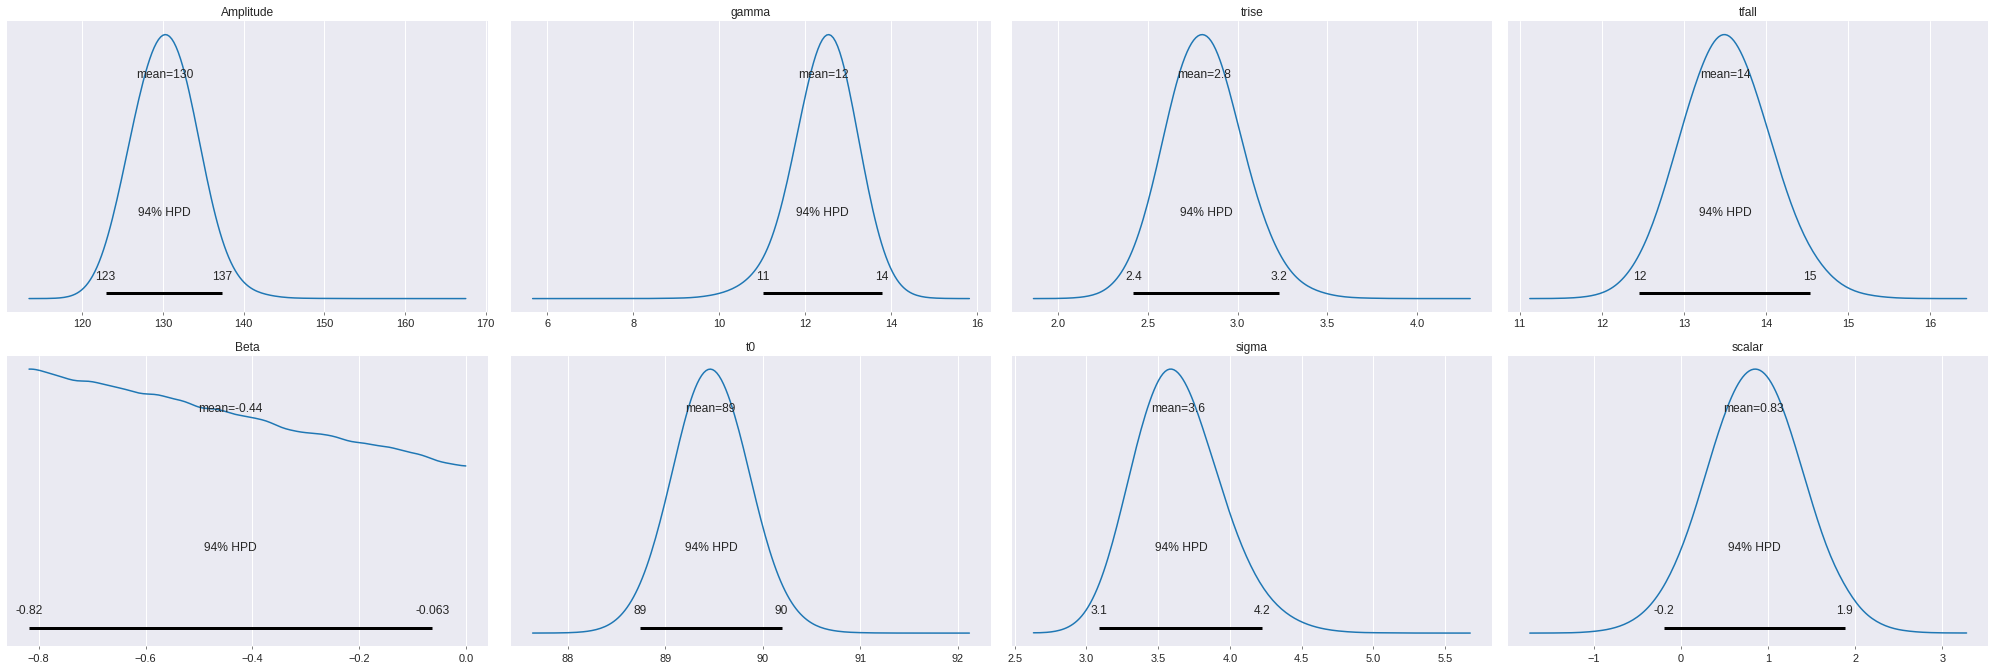

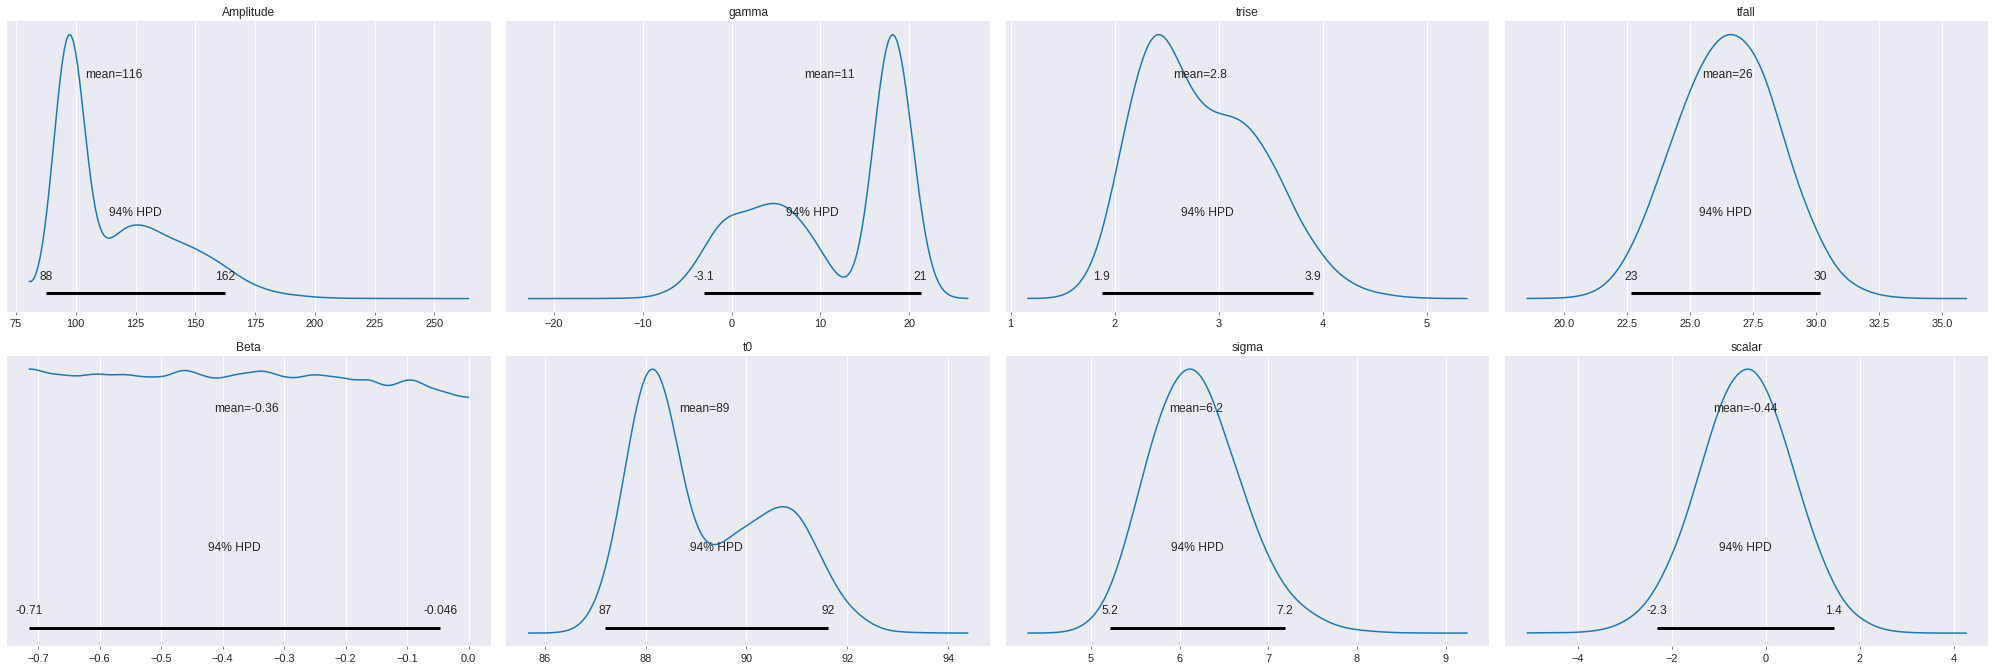

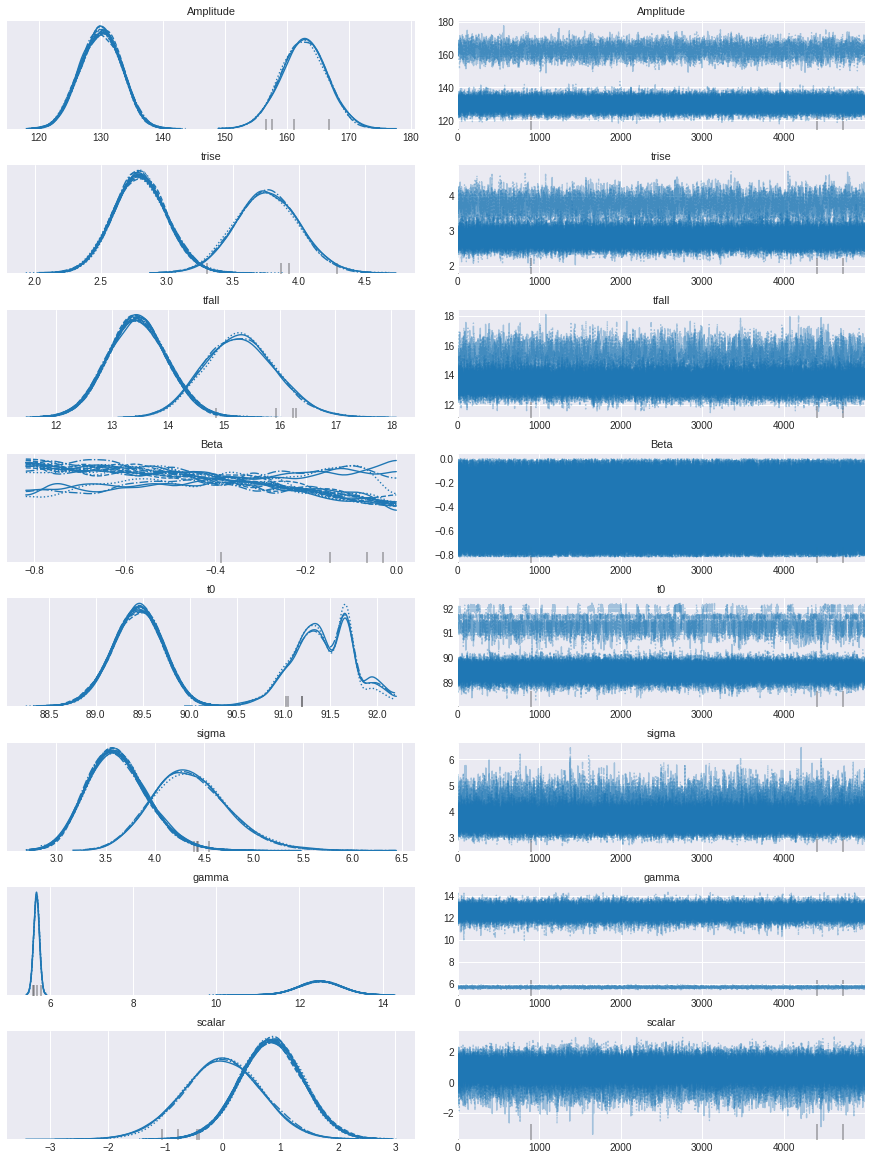

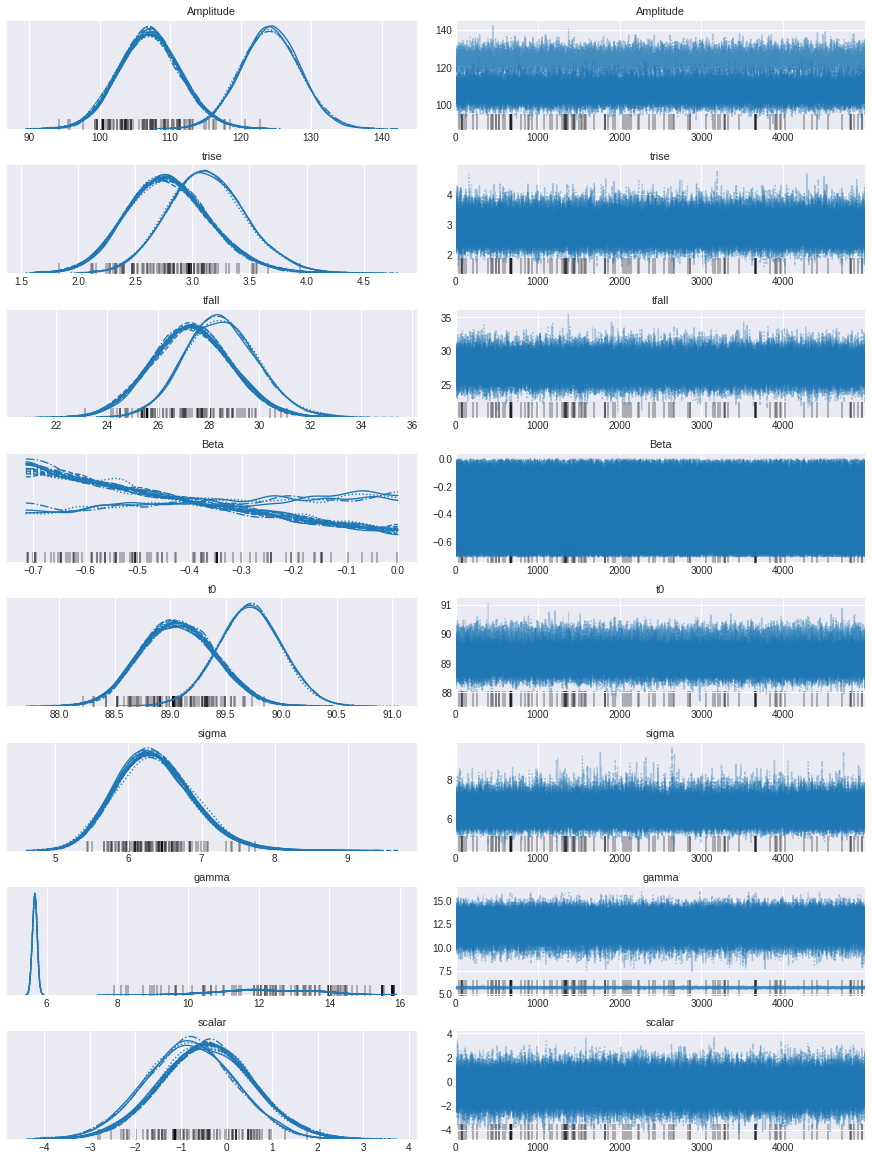

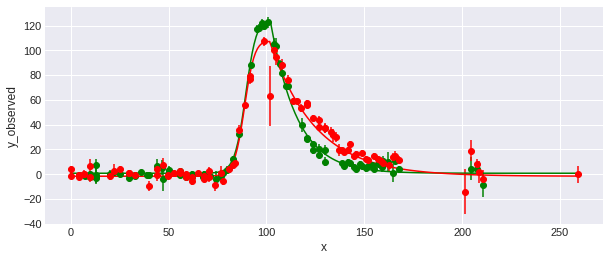

In [3]:
SuperNova_Analysis(file)